# Set up

In [1]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'
#!conda update conda -y

In [2]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata
## https://stackoverflow.com/questions/41385708/multiprocessing-example-giving-attributeerror
#import multiprocessing as mp # fails on IPython environment
import multiprocess as mp # provides Pool

# Preparation 1

In [3]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True

## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source

## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = [ 'sp_size', 'sn_size' ]
size_measure         = size_measures[1]
max_doc_size         = 10 # values larger than 10 take considerably longer to complete
min_doc_size         =  4

## preprocessing settings
lower_chars          = True
strip_accents        = True
add_boundaries       = True
boundary_symbol      = '#'  # requires more processing resource
if add_boundaries:
    hash_status = "-hashed"
else:
    hash_status = ""

## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
inclusion_degree      = 1    # Valid values are {0, 1, 2, ..., None}. With k, n-grams includes (n-k)-grams
max_gap_size_factor   = 0.53 # It takes time at valuers larger than 0.5 with larger n such as n = 5
max_gap_size          = round(max_doc_size * max_gap_size_factor) # This needs to be smaller than other cases.

## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"

## spell term と sound term の連結記号
pair_marker           = " :: "

## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
sp_term_type   = sp_term_types[3]
print(f"sp_term_type: {sp_term_type}")

## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
sn_term_type = sn_term_types[3]
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_4gram
sn_term_type: sn_4gram


In [4]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq               = 3 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold       = 0.1 # Larger values reveal deeper; 0.006 seems to be the smallest

In [5]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
## HDP
use_HDP         = True
max_n_topics    = 45
n_terms_to_show = 120

## LDA
n_topics  = max_n_topics # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"

## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 45
n_topics for LDA: 45
top_perplexity_reduct_rate: 0.33


In [6]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = [ ]
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [7]:
## select language and file
lang_names = {  'ar' : 'Arabic',  # 0
                'de' : 'German',  # 1
                'en' : 'English', # 2
                'es' : 'Spanish', # 3
                'fr' : 'French',  # 4
                'sw' : 'Swahili'  # 5
            }
#
lang_keys = [ 'ar', 'de', 'en', 'es', 'fr', 'sw' ]
#
lang_key  = lang_keys[4]
lang_name = lang_names[lang_key]
lang_attr = ""
print(f"lang_name: {lang_name} ({lang_attr}) [lang_key: {lang_key}]")
# aliases
target_lang_dict = lang_names
target_lang_keys = lang_keys
target_lang_key  = lang_key
target_lang_attr = lang_attr
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
if len(lang_attr) > 0:
    print(f"lang_attr: {lang_attr}")
    selected_files = [ file for file in files if lang_attr in file ]
else:
    selected_files = files
selected_files
if len(selected_files) == 0:
    exit()

lang_name: French () [lang_key: fr]
['data/open-dict-ipa/data1/fr_QC.csv.gz', 'data/open-dict-ipa/data1/fr_FR.csv.gz']


In [8]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
target_file = selected_files[0]
col_names = [ 'sp_word', 'sn_word' ]
if target_file.endswith(".gz"):
    with gzip.open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
else:
    with open(target_file, "rt") as f:
        raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,a,/a/
1,A,/a/
2,à,/a/
3,à aucun moment,/aokœ̃˞mɑɔ̯mæ̃/
4,à aucun prix,/aokœ̃˞pʁi/
...,...,...
245953,zyeutons,/zjøtõũ̯/
245954,zygomatique,/zɪgɑɔ̯mat͡sɪk/
245955,zygomatiques,/zɪgɑɔ̯mat͡sɪk/
245956,zygote,/zɪgɑɔ̯t/


In [9]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,a,a
1,a,a
2,à,a
3,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,à aucun prix,aokœ̃˞pʁi
...,...,...
245953,zyeutons,zjøtõũ̯
245954,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,zygote,zɪgɑɔ̯t


In [10]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(i + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_size', 'sn_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_sk2gram', 'sp_sk3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_sk2gram', 'sn_sk3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,a,a
1,2,2,a,a
2,3,3,à,a
3,4,4,à aucun moment,aokœ̃˞mɑɔ̯mæ̃
4,5,5,à aucun prix,aokœ̃˞pʁi
...,...,...,...,...
245953,245954,245954,zyeutons,zjøtõũ̯
245954,245955,245955,zygomatique,zɪgɑɔ̯mat͡sɪk
245955,245956,245956,zygomatiques,zɪgɑɔ̯mat͡sɪk
245956,245957,245957,zygote,zɪgɑɔ̯t


In [11]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 7379 (0.030) rows by discarding 238579 rows


In [12]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [13]:
## add size columns
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

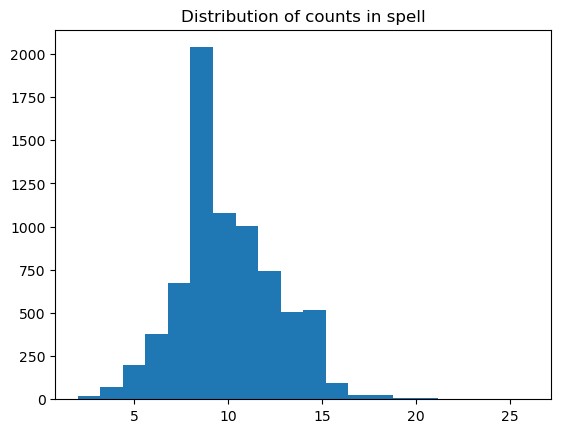

In [14]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

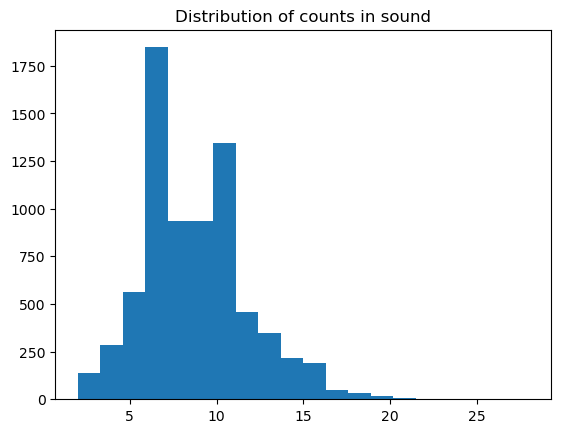

In [15]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [16]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_size part has less than 4 chars
discarding pairs whose sn_size part has more than 10 chars
2818 (0.382) pairs were removed
4561 pairs remain


In [17]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [18]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
98362,"[#, e, n, t, e, n, d, r, a, i, #]","[#, ɑ, ̃, t, ɑ, ̃, d, ʁ, a, #]"
193951,"[#, r, e, c, o, u, v, r, î, t, e, s, #]","[#, ʁ, ə, k, ʊ, v, ʁ, ɪ, t, #]"
239393,"[#, u, r, i, n, a, i, s, #]","[#, y, ʁ, ɪ, n, a, #]"
173084,"[#, p, i, c, a, r, d, #]","[#, p, ɪ, k, a, ʁ, #]"
95479,"[#, e, n, f, o, u, r, n, a, i, s, #]","[#, ɑ, ̃, f, ʊ, ʁ, n, a, #]"
...,...,...
13389,"[#, a, p, p, u, y, é, #]","[#, a, p, ɥ, i, j, e, #]"
16932,"[#, a, t, t, e, l, l, e, r, a, i, e, n, t, #]","[#, a, t, ə, l, a, ʁ, a, #]"
207292,"[#, r, e, v, e, n, d, a, i, t, #]","[#, ʁ, ə, v, ɑ, ̃, d, a, #]"
158697,"[#, n, é, c, r, o, s, a, i, s, #]","[#, n, e, k, ʁ, o, z, a, #]"


In [19]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('#', 9122),
 ('e', 4652),
 ('a', 4113),
 ('s', 4078),
 ('r', 3434),
 ('i', 3361),
 ('t', 2629),
 ('n', 2435),
 ('l', 1729),
 ('u', 1689)]

In [20]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('#', 9122),
 ('a', 4155),
 ('ʁ', 3173),
 ('e', 2157),
 ('s', 1745),
 ('t', 1397),
 ('ɪ', 1258),
 ('l', 1205),
 ('̯', 1143),
 ('ɑ', 1075)]

In [21]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [22]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [23]:
## generic n-gram generation function
def add_ngrams(dfx, n_for_ngram: int, prefix: str = "", skippy: bool = False, skippiness_symbol: str = "sk", max_distance = None, seg_joint: str = "", gap_mark: str = "…", inclusive: bool = True, inclusion_degree = None, check: bool = False):
    "add ngram col to the dfx given"
    import gen_ngrams
    ## set variable names
    source_var_name = f"{prefix}1gram"
    if skippy:
        target_var_name  = f"{prefix}{skippiness_symbol}{n_for_ngram}gram"
        if n_for_ngram == 2:
            sub_var_name = f"{prefix}{n_for_ngram - 1}gram"
        else:
            sub_var_name = f"{prefix}{skippiness_symbol}{n_for_ngram - 1}gram"
            
    else:
        target_var_name  = f"{prefix}{n_for_ngram}gram"
        sub_var_name     = f"{prefix}{n_for_ngram - 1}gram"
    if check:
        print(f"source_var_name: {source_var_name}")
        print(f"target_var_name: {target_var_name}")
        print(f"sub_var_name: {sub_var_name}")
        
    ## 1gram
    unigrams = dfx[source_var_name]
    
    ## ngram
    pool = mp.Pool (processes = max(os.cpu_count() - 1, 1))
    if skippy:
        ngrams = [ gen_ngrams.gen_skippy_ngrams(g, n = n_for_ngram, sep = seg_joint, missing_mark = gap_mark, max_distance = max_distance, check = check) for g in unigrams ]
    else:
        ngrams = [ gen_ngrams.gen_ngrams(g, n = n_for_ngram, sep = seg_joint, check = check) for g in unigrams ]
    
    ## make ngrams inclusive
    if inclusive:
        sub_ngrams = list(dfx[sub_var_name])
        if inclusion_degree is None:
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) > 0 ]
                if len(supplement) > 0:
                    gram.extend(supplement)
        else:
            min_size = (n_for_ngram - inclusion_degree)
            assert min_size >= 0
            for i, gram in enumerate(ngrams):
                assert len(ngrams) == len(sub_ngrams)
                supplement = sub_ngrams[i]
                supplement = [ g for g in supplement if len(g) >= min_size ]
                if len(supplement) > 0:
                    gram.extend(supplement)
    ## update df
    dfx[target_var_name] = ngrams
    print(dfx[target_var_name])

# Spell n-grams 生成

In [24]:
df.columns
#iter(df['sp_1gram'])

Index(['did', 'sid', 'sp_word', 'sn_word', 'sp_1gram', 'sn_1gram', 'sp_size',
       'sn_size'],
      dtype='object')

In [25]:
## sp_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#e, en, nt, te, en, nd, dr, ra, ai, i#, #, e,...
193951    [#r, re, ec, co, ou, uv, vr, rî, ît, te, es, s...
239393    [#u, ur, ri, in, na, ai, is, s#, #, u, r, i, n...
173084    [#p, pi, ic, ca, ar, rd, d#, #, p, i, c, a, r,...
95479     [#e, en, nf, fo, ou, ur, rn, na, ai, is, s#, #...
                                ...                        
13389     [#a, ap, pp, pu, uy, yé, é#, #, a, p, p, u, y,...
16932     [#a, at, tt, te, el, ll, le, er, ra, ai, ie, e...
207292    [#r, re, ev, ve, en, nd, da, ai, it, t#, #, r,...
158697    [#n, né, éc, cr, ro, os, sa, ai, is, s#, #, n,...
44429     [#c, co, ol, ll, li, ie, er, r#, #, c, o, l, l...
Name: sp_2gram, Length: 4561, dtype: object


In [26]:
## sp_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#en, ent, nte, ten, end, ndr, dra, rai, ai#, ...
193951    [#re, rec, eco, cou, ouv, uvr, vrî, rît, îte, ...
239393    [#ur, uri, rin, ina, nai, ais, is#, #u, ur, ri...
173084    [#pi, pic, ica, car, ard, rd#, #p, pi, ic, ca,...
95479     [#en, enf, nfo, fou, our, urn, rna, nai, ais, ...
                                ...                        
13389     [#ap, app, ppu, puy, uyé, yé#, #a, ap, pp, pu,...
16932     [#at, att, tte, tel, ell, lle, ler, era, rai, ...
207292    [#re, rev, eve, ven, end, nda, dai, ait, it#, ...
158697    [#né, néc, écr, cro, ros, osa, sai, ais, is#, ...
44429     [#co, col, oll, lli, lie, ier, er#, #c, co, ol...
Name: sp_3gram, Length: 4561, dtype: object


In [27]:
## sp_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ent, ente, nten, tend, endr, ndra, drai, rai...
193951    [#rec, reco, ecou, couv, ouvr, uvrî, vrît, rît...
239393    [#uri, urin, rina, inai, nais, ais#, #ur, uri,...
173084    [#pic, pica, icar, card, ard#, #pi, pic, ica, ...
95479     [#enf, enfo, nfou, four, ourn, urna, rnai, nai...
                                ...                        
13389     [#app, appu, ppuy, puyé, uyé#, #ap, app, ppu, ...
16932     [#att, atte, ttel, tell, elle, ller, lera, era...
207292    [#rev, reve, even, vend, enda, ndai, dait, ait...
158697    [#néc, nécr, écro, cros, rosa, osai, sais, ais...
44429     [#col, coll, olli, llie, lier, ier#, #co, col,...
Name: sp_4gram, Length: 4561, dtype: object


In [28]:
## sp_5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [29]:
## sp_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#e, #…n, #…t, #…e, en, e…t, e…e, nt, n…e, te,...
193951    [#r, #…e, #…c, #…o, re, r…c, r…o, ec, e…o, co,...
239393    [#u, #…r, #…i, #…n, ur, u…i, u…n, ri, r…n, in,...
173084    [#p, #…i, #…c, #…a, pi, p…c, p…a, ic, i…a, ca,...
95479     [#e, #…n, #…f, #…o, en, e…f, e…o, nf, n…o, fo,...
                                ...                        
13389     [#a, #…p, #…p, #…u, ap, a…p, a…u, pp, p…u, pu,...
16932     [#a, #…t, #…t, #…e, at, a…t, a…e, tt, t…e, te,...
207292    [#r, #…e, #…v, #…e, re, r…v, r…e, ev, e…e, ve,...
158697    [#n, #…é, #…c, #…r, né, n…c, n…r, éc, é…r, cr,...
44429     [#c, #…o, #…l, #…l, co, c…l, c…l, ol, o…l, ll,...
Name: sp_sk2gram, Length: 4561, dtype: object


In [30]:
## sp_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#en, #e…t, #e…e, #…nt, #…n…e, #…te, ent, en…e...
193951    [#re, #r…c, #r…o, #…ec, #…e…o, #…co, rec, re…o...
239393    [#ur, #u…i, #u…n, #…ri, #…r…n, #…in, uri, ur…n...
173084    [#pi, #p…c, #p…a, #…ic, #…i…a, #…ca, pic, pi…a...
95479     [#en, #e…f, #e…o, #…nf, #…n…o, #…fo, enf, en…o...
                                ...                        
13389     [#ap, #a…p, #a…u, #…pp, #…p…u, #…pu, app, ap…u...
16932     [#at, #a…t, #a…e, #…tt, #…t…e, #…te, att, at…e...
207292    [#re, #r…v, #r…e, #…ev, #…e…e, #…ve, rev, re…e...
158697    [#né, #n…c, #n…r, #…éc, #…é…r, #…cr, néc, né…r...
44429     [#co, #c…l, #c…l, #…ol, #…o…l, #…ll, col, co…l...
Name: sp_sk3gram, Length: 4561, dtype: object


In [31]:
## sp_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ent, #en…e, #e…te, #…nte, ente, ente, ent…n,...
193951    [#rec, #re…o, #r…co, #…eco, reco, reco, rec…u,...
239393    [#uri, #ur…n, #u…in, #…rin, urin, urin, uri…a,...
173084    [#pic, #pi…a, #p…ca, #…ica, pica, pica, pic…r,...
95479     [#enf, #en…o, #e…fo, #…nfo, enfo, enfo, enf…u,...
                                ...                        
13389     [#app, #ap…u, #a…pu, #…ppu, appu, appu, app…y,...
16932     [#att, #at…e, #a…te, #…tte, atte, atte, att…l,...
207292    [#rev, #re…e, #r…ve, #…eve, reve, reve, rev…n,...
158697    [#néc, #né…r, #n…cr, #…écr, nécr, nécr, néc…o,...
44429     [#col, #co…l, #c…ll, #…oll, coll, coll, col…i,...
Name: sp_sk4gram, Length: 4561, dtype: object


In [32]:
## sp_sk5gram の追加
if "5gram" in sp_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sp_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [33]:
## check result
if "5gram" in sp_term_type:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram', 'sp_sk5gram' ]
else:
    var_names = [ 'sp_word', 'sp_sk2gram', 'sp_sk3gram', 'sp_sk4gram' ]
df[var_names]

,sp_word,sp_sk2gram,sp_sk3gram,sp_sk4gram
98362,#entendrai#,"[#e, #…n, #…t, #…e, en, e…t, e…e, nt, n…e, te,...","[#en, #e…t, #e…e, #…nt, #…n…e, #…te, ent, en…e...","[#ent, #en…e, #e…te, #…nte, ente, ente, ent…n,..."
193951,#recouvrîtes#,"[#r, #…e, #…c, #…o, re, r…c, r…o, ec, e…o, co,...","[#re, #r…c, #r…o, #…ec, #…e…o, #…co, rec, re…o...","[#rec, #re…o, #r…co, #…eco, reco, reco, rec…u,..."
239393,#urinais#,"[#u, #…r, #…i, #…n, ur, u…i, u…n, ri, r…n, in,...","[#ur, #u…i, #u…n, #…ri, #…r…n, #…in, uri, ur…n...","[#uri, #ur…n, #u…in, #…rin, urin, urin, uri…a,..."
173084,#picard#,"[#p, #…i, #…c, #…a, pi, p…c, p…a, ic, i…a, ca,...","[#pi, #p…c, #p…a, #…ic, #…i…a, #…ca, pic, pi…a...","[#pic, #pi…a, #p…ca, #…ica, pica, pica, pic…r,..."
95479,#enfournais#,"[#e, #…n, #…f, #…o, en, e…f, e…o, nf, n…o, fo,...","[#en, #e…f, #e…o, #…nf, #…n…o, #…fo, enf, en…o...","[#enf, #en…o, #e…fo, #…nfo, enfo, enfo, enf…u,..."
...,...,...,...,...
13389,#appuyé#,"[#a, #…p, #…p, #…u, ap, a…p, a…u, pp, p…u, pu,...","[#ap, #a…p, #a…u, #…pp, #…p…u, #…pu, app, ap…u...","[#app, #ap…u, #a…pu, #…ppu, appu, appu, app…y,..."
16932,#attelleraient#,"[#a, #…t, #…t, #…e, at, a…t, a…e, tt, t…e, te,...","[#at, #a…t, #a…e, #…tt, #…t…e, #…te, att, at…e...","[#att, #at…e, #a…te, #…tte, atte, atte, att…l,..."
207292,#revendait#,"[#r, #…e, #…v, #…e, re, r…v, r…e, ev, e…e, ve,...","[#re, #r…v, #r…e, #…ev, #…e…e, #…ve, rev, re…e...","[#rev, #re…e, #r…ve, #…eve, reve, reve, rev…n,..."
158697,#nécrosais#,"[#n, #…é, #…c, #…r, né, n…c, n…r, éc, é…r, cr,...","[#né, #n…c, #n…r, #…éc, #…é…r, #…cr, néc, né…r...","[#néc, #né…r, #n…cr, #…écr, nécr, nécr, néc…o,..."


# Sound n-grams 生成

In [34]:
## sn_2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ, ɑ̃, ̃t, tɑ, ɑ̃, ̃d, dʁ, ʁa, a#, #, ɑ, ̃, ...
193951    [#ʁ, ʁə, ək, kʊ, ʊv, vʁ, ʁɪ, ɪt, t#, #, ʁ, ə, ...
239393        [#y, yʁ, ʁɪ, ɪn, na, a#, #, y, ʁ, ɪ, n, a, #]
173084        [#p, pɪ, ɪk, ka, aʁ, ʁ#, #, p, ɪ, k, a, ʁ, #]
95479     [#ɑ, ɑ̃, ̃f, fʊ, ʊʁ, ʁn, na, a#, #, ɑ, ̃, f, ʊ...
                                ...                        
13389     [#a, ap, pɥ, ɥi, ij, je, e#, #, a, p, ɥ, i, j,...
16932     [#a, at, tə, əl, la, aʁ, ʁa, a#, #, a, t, ə, l...
207292    [#ʁ, ʁə, əv, vɑ, ɑ̃, ̃d, da, a#, #, ʁ, ə, v, ɑ...
158697    [#n, ne, ek, kʁ, ʁo, oz, za, a#, #, n, e, k, ʁ...
44429     [#k, kɑ, ɑɔ, ɔ̯, ̯l, lj, je, e#, #, k, ɑ, ɔ, ̯...
Name: sn_2gram, Length: 4561, dtype: object


In [35]:
## sn_3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ̃, ɑ̃t, ̃tɑ, tɑ̃, ɑ̃d, ̃dʁ, dʁa, ʁa#, #ɑ, ɑ...
193951    [#ʁə, ʁək, əkʊ, kʊv, ʊvʁ, vʁɪ, ʁɪt, ɪt#, #ʁ, ʁ...
239393    [#yʁ, yʁɪ, ʁɪn, ɪna, na#, #y, yʁ, ʁɪ, ɪn, na, a#]
173084    [#pɪ, pɪk, ɪka, kaʁ, aʁ#, #p, pɪ, ɪk, ka, aʁ, ʁ#]
95479     [#ɑ̃, ɑ̃f, ̃fʊ, fʊʁ, ʊʁn, ʁna, na#, #ɑ, ɑ̃, ̃f...
                                ...                        
13389     [#ap, apɥ, pɥi, ɥij, ije, je#, #a, ap, pɥ, ɥi,...
16932     [#at, atə, təl, əla, laʁ, aʁa, ʁa#, #a, at, tə...
207292    [#ʁə, ʁəv, əvɑ, vɑ̃, ɑ̃d, ̃da, da#, #ʁ, ʁə, əv...
158697    [#ne, nek, ekʁ, kʁo, ʁoz, oza, za#, #n, ne, ek...
44429     [#kɑ, kɑɔ, ɑɔ̯, ɔ̯l, ̯lj, lje, je#, #k, kɑ, ɑɔ...
Name: sn_3gram, Length: 4561, dtype: object


In [36]:
## sn_4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ̃t, ɑ̃tɑ, ̃tɑ̃, tɑ̃d, ɑ̃dʁ, ̃dʁa, dʁa#, #ɑ̃...
193951    [#ʁək, ʁəkʊ, əkʊv, kʊvʁ, ʊvʁɪ, vʁɪt, ʁɪt#, #ʁə...
239393    [#yʁɪ, yʁɪn, ʁɪna, ɪna#, #yʁ, yʁɪ, ʁɪn, ɪna, na#]
173084    [#pɪk, pɪka, ɪkaʁ, kaʁ#, #pɪ, pɪk, ɪka, kaʁ, aʁ#]
95479     [#ɑ̃f, ɑ̃fʊ, ̃fʊʁ, fʊʁn, ʊʁna, ʁna#, #ɑ̃, ɑ̃f,...
                                ...                        
13389     [#apɥ, apɥi, pɥij, ɥije, ije#, #ap, apɥ, pɥi, ...
16932     [#atə, atəl, təla, əlaʁ, laʁa, aʁa#, #at, atə,...
207292    [#ʁəv, ʁəvɑ, əvɑ̃, vɑ̃d, ɑ̃da, ̃da#, #ʁə, ʁəv,...
158697    [#nek, nekʁ, ekʁo, kʁoz, ʁoza, oza#, #ne, nek,...
44429     [#kɑɔ, kɑɔ̯, ɑɔ̯l, ɔ̯lj, ̯lje, lje#, #kɑ, kɑɔ,...
Name: sn_4gram, Length: 4561, dtype: object


In [37]:
## sn_5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [38]:
## sn_sk2gram の追加
add_ngrams(df, n_for_ngram = 2, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ, #…̃, #…t, #…ɑ, ɑ̃, ɑ…t, ɑ…ɑ, ̃t, ̃…ɑ, tɑ,...
193951    [#ʁ, #…ə, #…k, #…ʊ, ʁə, ʁ…k, ʁ…ʊ, ək, ə…ʊ, kʊ,...
239393    [#y, #…ʁ, #…ɪ, #…n, yʁ, y…ɪ, y…n, ʁɪ, ʁ…n, ɪn,...
173084    [#p, #…ɪ, #…k, #…a, pɪ, p…k, p…a, ɪk, ɪ…a, ka,...
95479     [#ɑ, #…̃, #…f, #…ʊ, ɑ̃, ɑ…f, ɑ…ʊ, ̃f, ̃…ʊ, fʊ,...
                                ...                        
13389     [#a, #…p, #…ɥ, #…i, ap, a…ɥ, a…i, pɥ, p…i, ɥi,...
16932     [#a, #…t, #…ə, #…l, at, a…ə, a…l, tə, t…l, əl,...
207292    [#ʁ, #…ə, #…v, #…ɑ, ʁə, ʁ…v, ʁ…ɑ, əv, ə…ɑ, vɑ,...
158697    [#n, #…e, #…k, #…ʁ, ne, n…k, n…ʁ, ek, e…ʁ, kʁ,...
44429     [#k, #…ɑ, #…ɔ, #…̯, kɑ, k…ɔ, k…̯, ɑɔ, ɑ…̯, ɔ̯,...
Name: sn_sk2gram, Length: 4561, dtype: object


In [39]:
## sn_sk3gram の追加
add_ngrams(df, n_for_ngram = 3, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ̃, #ɑ…t, #ɑ…ɑ, #…̃t, #…̃…ɑ, #…tɑ, ɑ̃t, ɑ̃…ɑ...
193951    [#ʁə, #ʁ…k, #ʁ…ʊ, #…ək, #…ə…ʊ, #…kʊ, ʁək, ʁə…ʊ...
239393    [#yʁ, #y…ɪ, #y…n, #…ʁɪ, #…ʁ…n, #…ɪn, yʁɪ, yʁ…n...
173084    [#pɪ, #p…k, #p…a, #…ɪk, #…ɪ…a, #…ka, pɪk, pɪ…a...
95479     [#ɑ̃, #ɑ…f, #ɑ…ʊ, #…̃f, #…̃…ʊ, #…fʊ, ɑ̃f, ɑ̃…ʊ...
                                ...                        
13389     [#ap, #a…ɥ, #a…i, #…pɥ, #…p…i, #…ɥi, apɥ, ap…i...
16932     [#at, #a…ə, #a…l, #…tə, #…t…l, #…əl, atə, at…l...
207292    [#ʁə, #ʁ…v, #ʁ…ɑ, #…əv, #…ə…ɑ, #…vɑ, ʁəv, ʁə…ɑ...
158697    [#ne, #n…k, #n…ʁ, #…ek, #…e…ʁ, #…kʁ, nek, ne…ʁ...
44429     [#kɑ, #k…ɔ, #k…̯, #…ɑɔ, #…ɑ…̯, #…ɔ̯, kɑɔ, kɑ…̯...
Name: sn_sk3gram, Length: 4561, dtype: object


In [40]:
## sn_sk4gram の追加
add_ngrams(df, n_for_ngram = 4, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

98362     [#ɑ̃t, #ɑ̃…ɑ, #ɑ…tɑ, #…̃tɑ, ɑ̃tɑ, ɑ̃tɑ, ɑ̃t…̃,...
193951    [#ʁək, #ʁə…ʊ, #ʁ…kʊ, #…əkʊ, ʁəkʊ, ʁəkʊ, ʁək…v,...
239393    [#yʁɪ, #yʁ…n, #y…ɪn, #…ʁɪn, yʁɪn, yʁɪn, yʁɪ…a,...
173084    [#pɪk, #pɪ…a, #p…ka, #…ɪka, pɪka, pɪka, pɪk…ʁ,...
95479     [#ɑ̃f, #ɑ̃…ʊ, #ɑ…fʊ, #…̃fʊ, ɑ̃fʊ, ɑ̃fʊ, ɑ̃f…ʁ,...
                                ...                        
13389     [#apɥ, #ap…i, #a…ɥi, #…pɥi, apɥi, apɥi, apɥ…j,...
16932     [#atə, #at…l, #a…əl, #…təl, atəl, atəl, atə…a,...
207292    [#ʁəv, #ʁə…ɑ, #ʁ…vɑ, #…əvɑ, ʁəvɑ, ʁəvɑ, ʁəv…̃,...
158697    [#nek, #ne…ʁ, #n…kʁ, #…ekʁ, nekʁ, nekʁ, nek…o,...
44429     [#kɑɔ, #kɑ…̯, #k…ɔ̯, #…ɑɔ̯, kɑɔ̯, kɑɔ̯, kɑɔ…l,...
Name: sn_sk4gram, Length: 4561, dtype: object


In [41]:
## sn_sk5gram の追加
if "5gram" in sn_term_type:
    add_ngrams(df, n_for_ngram = 5, prefix = "sn_", skippy = True, max_distance = max_gap_size, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [42]:
## check result
if "5gram" in sn_term_type:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram', 'sn_sk5gram' ]
else:
    var_names = [ 'sn_word', 'sn_sk2gram', 'sn_sk3gram', 'sn_sk4gram' ]
df[var_names]

,sn_word,sn_sk2gram,sn_sk3gram,sn_sk4gram
98362,#ɑ̃tɑ̃dʁa#,"[#ɑ, #…̃, #…t, #…ɑ, ɑ̃, ɑ…t, ɑ…ɑ, ̃t, ̃…ɑ, tɑ,...","[#ɑ̃, #ɑ…t, #ɑ…ɑ, #…̃t, #…̃…ɑ, #…tɑ, ɑ̃t, ɑ̃…ɑ...","[#ɑ̃t, #ɑ̃…ɑ, #ɑ…tɑ, #…̃tɑ, ɑ̃tɑ, ɑ̃tɑ, ɑ̃t…̃,..."
193951,#ʁəkʊvʁɪt#,"[#ʁ, #…ə, #…k, #…ʊ, ʁə, ʁ…k, ʁ…ʊ, ək, ə…ʊ, kʊ,...","[#ʁə, #ʁ…k, #ʁ…ʊ, #…ək, #…ə…ʊ, #…kʊ, ʁək, ʁə…ʊ...","[#ʁək, #ʁə…ʊ, #ʁ…kʊ, #…əkʊ, ʁəkʊ, ʁəkʊ, ʁək…v,..."
239393,#yʁɪna#,"[#y, #…ʁ, #…ɪ, #…n, yʁ, y…ɪ, y…n, ʁɪ, ʁ…n, ɪn,...","[#yʁ, #y…ɪ, #y…n, #…ʁɪ, #…ʁ…n, #…ɪn, yʁɪ, yʁ…n...","[#yʁɪ, #yʁ…n, #y…ɪn, #…ʁɪn, yʁɪn, yʁɪn, yʁɪ…a,..."
173084,#pɪkaʁ#,"[#p, #…ɪ, #…k, #…a, pɪ, p…k, p…a, ɪk, ɪ…a, ka,...","[#pɪ, #p…k, #p…a, #…ɪk, #…ɪ…a, #…ka, pɪk, pɪ…a...","[#pɪk, #pɪ…a, #p…ka, #…ɪka, pɪka, pɪka, pɪk…ʁ,..."
95479,#ɑ̃fʊʁna#,"[#ɑ, #…̃, #…f, #…ʊ, ɑ̃, ɑ…f, ɑ…ʊ, ̃f, ̃…ʊ, fʊ,...","[#ɑ̃, #ɑ…f, #ɑ…ʊ, #…̃f, #…̃…ʊ, #…fʊ, ɑ̃f, ɑ̃…ʊ...","[#ɑ̃f, #ɑ̃…ʊ, #ɑ…fʊ, #…̃fʊ, ɑ̃fʊ, ɑ̃fʊ, ɑ̃f…ʁ,..."
...,...,...,...,...
13389,#apɥije#,"[#a, #…p, #…ɥ, #…i, ap, a…ɥ, a…i, pɥ, p…i, ɥi,...","[#ap, #a…ɥ, #a…i, #…pɥ, #…p…i, #…ɥi, apɥ, ap…i...","[#apɥ, #ap…i, #a…ɥi, #…pɥi, apɥi, apɥi, apɥ…j,..."
16932,#atəlaʁa#,"[#a, #…t, #…ə, #…l, at, a…ə, a…l, tə, t…l, əl,...","[#at, #a…ə, #a…l, #…tə, #…t…l, #…əl, atə, at…l...","[#atə, #at…l, #a…əl, #…təl, atəl, atəl, atə…a,..."
207292,#ʁəvɑ̃da#,"[#ʁ, #…ə, #…v, #…ɑ, ʁə, ʁ…v, ʁ…ɑ, əv, ə…ɑ, vɑ,...","[#ʁə, #ʁ…v, #ʁ…ɑ, #…əv, #…ə…ɑ, #…vɑ, ʁəv, ʁə…ɑ...","[#ʁəv, #ʁə…ɑ, #ʁ…vɑ, #…əvɑ, ʁəvɑ, ʁəvɑ, ʁəv…̃,..."
158697,#nekʁoza#,"[#n, #…e, #…k, #…ʁ, ne, n…k, n…ʁ, ek, e…ʁ, kʁ,...","[#ne, #n…k, #n…ʁ, #…ek, #…e…ʁ, #…kʁ, nek, ne…ʁ...","[#nek, #ne…ʁ, #n…kʁ, #…ekʁ, nekʁ, nekʁ, nek…o,..."


# Pair = sp term :: sn term の生成

In [43]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [44]:
## random sampling
import random
random.sample(paired_terms, 1)

[['#pou :: #pʊd',
  '#pou :: pʊdʁ',
  '#pou :: ʊdʁw',
  '#pou :: dʁwa',
  '#pou :: ʁwaj',
  '#pou :: waja',
  '#pou :: aja#',
  '#pou :: #pʊ',
  '#pou :: pʊd',
  '#pou :: ʊdʁ',
  '#pou :: dʁw',
  '#pou :: ʁwa',
  '#pou :: waj',
  '#pou :: aja',
  '#pou :: ja#',
  'poud :: #pʊd',
  'poud :: pʊdʁ',
  'poud :: ʊdʁw',
  'poud :: dʁwa',
  'poud :: ʁwaj',
  'poud :: waja',
  'poud :: aja#',
  'poud :: #pʊ',
  'poud :: pʊd',
  'poud :: ʊdʁ',
  'poud :: dʁw',
  'poud :: ʁwa',
  'poud :: waj',
  'poud :: aja',
  'poud :: ja#',
  'oudr :: #pʊd',
  'oudr :: pʊdʁ',
  'oudr :: ʊdʁw',
  'oudr :: dʁwa',
  'oudr :: ʁwaj',
  'oudr :: waja',
  'oudr :: aja#',
  'oudr :: #pʊ',
  'oudr :: pʊd',
  'oudr :: ʊdʁ',
  'oudr :: dʁw',
  'oudr :: ʁwa',
  'oudr :: waj',
  'oudr :: aja',
  'oudr :: ja#',
  'udro :: #pʊd',
  'udro :: pʊdʁ',
  'udro :: ʊdʁw',
  'udro :: dʁwa',
  'udro :: ʁwaj',
  'udro :: waja',
  'udro :: aja#',
  'udro :: #pʊ',
  'udro :: pʊd',
  'udro :: ʊdʁ',
  'udro :: dʁw',
  'udro :: ʁwa',
  '

In [45]:
## number of sentences
print(len(paired_terms))

4561


In [46]:
## total number of units
sum(map(len, paired_terms))

1012671

In [47]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
98362,#entendrai#,#ɑ̃tɑ̃dʁa#,"[#ent :: #ɑ̃t, #ent :: ɑ̃tɑ, #ent :: ̃tɑ̃, #en..."
193951,#recouvrîtes#,#ʁəkʊvʁɪt#,"[#rec :: #ʁək, #rec :: ʁəkʊ, #rec :: əkʊv, #re..."
239393,#urinais#,#yʁɪna#,"[#uri :: #yʁɪ, #uri :: yʁɪn, #uri :: ʁɪna, #ur..."
173084,#picard#,#pɪkaʁ#,"[#pic :: #pɪk, #pic :: pɪka, #pic :: ɪkaʁ, #pi..."
95479,#enfournais#,#ɑ̃fʊʁna#,"[#enf :: #ɑ̃f, #enf :: ɑ̃fʊ, #enf :: ̃fʊʁ, #en..."
...,...,...,...
13389,#appuyé#,#apɥije#,"[#app :: #apɥ, #app :: apɥi, #app :: pɥij, #ap..."
16932,#attelleraient#,#atəlaʁa#,"[#att :: #atə, #att :: atəl, #att :: təla, #at..."
207292,#revendait#,#ʁəvɑ̃da#,"[#rev :: #ʁəv, #rev :: ʁəvɑ, #rev :: əvɑ̃, #re..."
158697,#nécrosais#,#nekʁoza#,"[#néc :: #nek, #néc :: nekʁ, #néc :: ekʁo, #né..."


# LDA/HDP の実行

In [48]:
## build DTM
from gensim.corpora.dictionary import Dictionary

pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)

## check
print(pair_diction) # print(..) is required for inspection

Dictionary<674210 unique tokens: ['#en :: #ɑ̃', '#en :: #ɑ̃t', '#en :: dʁa', '#en :: dʁa#', '#en :: tɑ̃']...>


In [49]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)

if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 3
abuse filter: 0.1
term filtering applied
Dictionary<57949 unique tokens: ['#en :: #ɑ̃', '#en :: #ɑ̃t', '#en :: ɑ̃d', '#en :: ɑ̃t', '#en :: ʁa#']...>


In [50]:
## build corpus
print(f"Building pair corpus ...")
pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
print(f"Number of documents: {len(pair_corpus)}")

## sanitize corpus for HDP model
size0 = len(pair_corpus)
pair_corpus = [ doc for doc in pair_corpus if len(doc) > 0 ]
size1 = len(pair_corpus)
print(f"{size0 - size1} empty docs are removed out from pair_corpus")
check = False
if check:
    print(random.sample(pair_corpus, 3))

Building pair corpus ...
Number of documents: 4561
7 empty docs are removed out from pair_corpus


In [51]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 45


# pyLDAvis の実行

In [55]:
##!conda install pyLDAvis
#!pip install pyLDAvis
#!conda update conda -y

  Obtaining dependency information for pyLDAvis from https://files.pythonhosted.org/packages/6b/5a/66364c6799f2362bfb9b7100bc1ce6ffcdfe7f17e8d2e85a591bfe427643/pyLDAvis-3.4.1-py3-none-any.whl.metadata
  Obtaining dependency information for funcy from https://files.pythonhosted.org/packages/d5/08/c2409cb01d5368dcfedcbaffa7d044cc8957d57a9d0855244a5eb4709d30/funcy-2.0-py2.py3-none-any.whl.metadata
Using cached pyLDAvis-3.4.1-py3-none-any.whl (2.6 MB)
Using cached funcy-2.0-py2.py3-none-any.whl (30 kB)
Channels:
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [56]:
%%capture --no-display

## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis

installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()

## set variable names
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used   = pair_corpus
diction_used  = pair_diction

## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
##
pyLDAvis.display(vis_data)

In [57]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = 0
	if len(lang_attr) > 0:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{lang_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"
	else:
		vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}{hash_status}-abuse={term_abuse_threshold}.html"	
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [58]:
## save topic structures
hdp_topics = pair_hdp.show_topics(num_topics = max_n_topics,
                               num_words = n_terms_to_show, formatted = False)
hdp_dict = { tid: values for tid, values in hdp_topics }
## convert to Pandas dataframe
topics_df = pd.DataFrame.from_dict(hdp_dict)
lang_dir_name = lang_name
target_class = "pair"
term_type = f"{sp_term_type}-{sn_term_type}"
accent_status = "-unaccented"
#
pair_hdp_topics_out = f"results/terms-by-topics-raw/{lang_dir_name}/{target_lang_dict[target_lang_key]}-{target_class}-topics{max_n_topics}-{term_type}{accent_status}.csv"
topics_df.to_csv(pair_hdp_topics_out, header = False, index = None)

# t-SNE を使った可視化

In [59]:
## t-SNE の実行
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 15


In [60]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go

## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [61]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Users/kowk/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, num_words = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

In [212]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)